In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import glob
import tqdm
import os
import PIL
from fastai.vision.all import *
from fastai.basics import *

print(torch.__version__)

1.7.1


In [4]:
import sys
import gc
import shutil

In [5]:
#!pip install -q git+https://github.com/tmabraham/UPIT.git

In [6]:
from upit.models.cyclegan import *
from upit.inference.cyclegan import *
from upit.train.cyclegan import *
from upit.data.unpaired import *

In [7]:
torch.cuda.device_count()

1

In [8]:
torch.cuda.set_device(0)

In [9]:
! nvidia-smi

Sun Jan  3 17:04:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    18W / 220W |    168MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
PATH=f'exp/MonetGan'

In [11]:
path = Path(PATH);
for p in path.ls():
    print(p)

exp/MonetGan/monet_jpg
exp/MonetGan/Test_jpg
exp/MonetGan/monet_tfrec
exp/MonetGan/photo_tfrec
exp/MonetGan/photo_jpg
exp/MonetGan/Test_Pred_jpg


In [12]:
photo = path/'photo_jpg'
monet = path/'monet_jpg'

In [13]:
monet_files = get_image_files(monet)
photo_files = get_image_files(photo)

In [14]:
monet_files, photo_files

((#300) [Path('exp/MonetGan/monet_jpg/281b73fb5e.jpg'),Path('exp/MonetGan/monet_jpg/049e293b93.jpg'),Path('exp/MonetGan/monet_jpg/2f90c99e10.jpg'),Path('exp/MonetGan/monet_jpg/1f22663e72.jpg'),Path('exp/MonetGan/monet_jpg/fb93438ff9.jpg'),Path('exp/MonetGan/monet_jpg/a8fbbe3eb1.jpg'),Path('exp/MonetGan/monet_jpg/07fcaee35f.jpg'),Path('exp/MonetGan/monet_jpg/f821791c85.jpg'),Path('exp/MonetGan/monet_jpg/9ae6552353.jpg'),Path('exp/MonetGan/monet_jpg/79292e1434.jpg')...],
 (#7038) [Path('exp/MonetGan/photo_jpg/1cb96210e6.jpg'),Path('exp/MonetGan/photo_jpg/915b936cdd.jpg'),Path('exp/MonetGan/photo_jpg/806723cc78.jpg'),Path('exp/MonetGan/photo_jpg/e714c3661f.jpg'),Path('exp/MonetGan/photo_jpg/3b3fd02a40.jpg'),Path('exp/MonetGan/photo_jpg/af98779f2f.jpg'),Path('exp/MonetGan/photo_jpg/2854ebb127.jpg'),Path('exp/MonetGan/photo_jpg/59bf7066cc.jpg'),Path('exp/MonetGan/photo_jpg/76461faf34.jpg'),Path('exp/MonetGan/photo_jpg/f969505f84.jpg')...])

# Monet Paintings

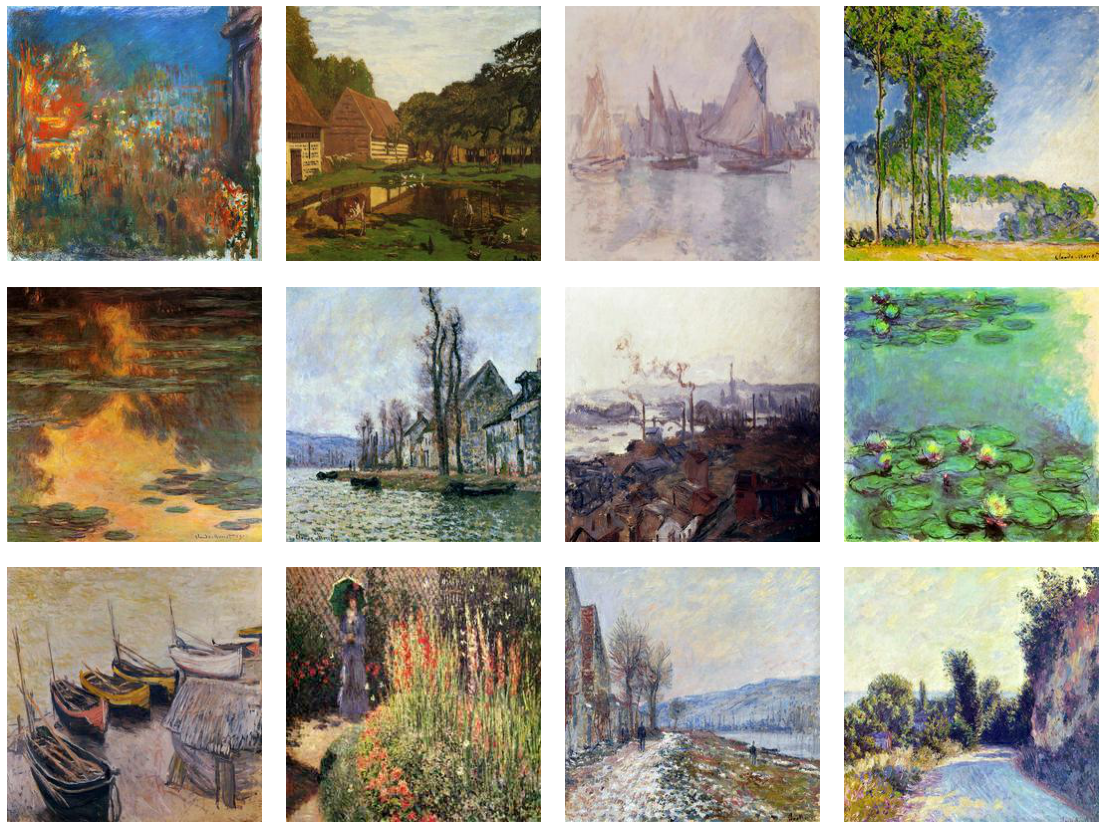

In [15]:
fig = plt.figure(1,figsize=(20,15))
columns = 4
rows = 3
for i in range(rows*columns):
    num = random.randint(2,300)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(PIL.Image.open(monet_files[num]))
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

# Test mages to be Transformed

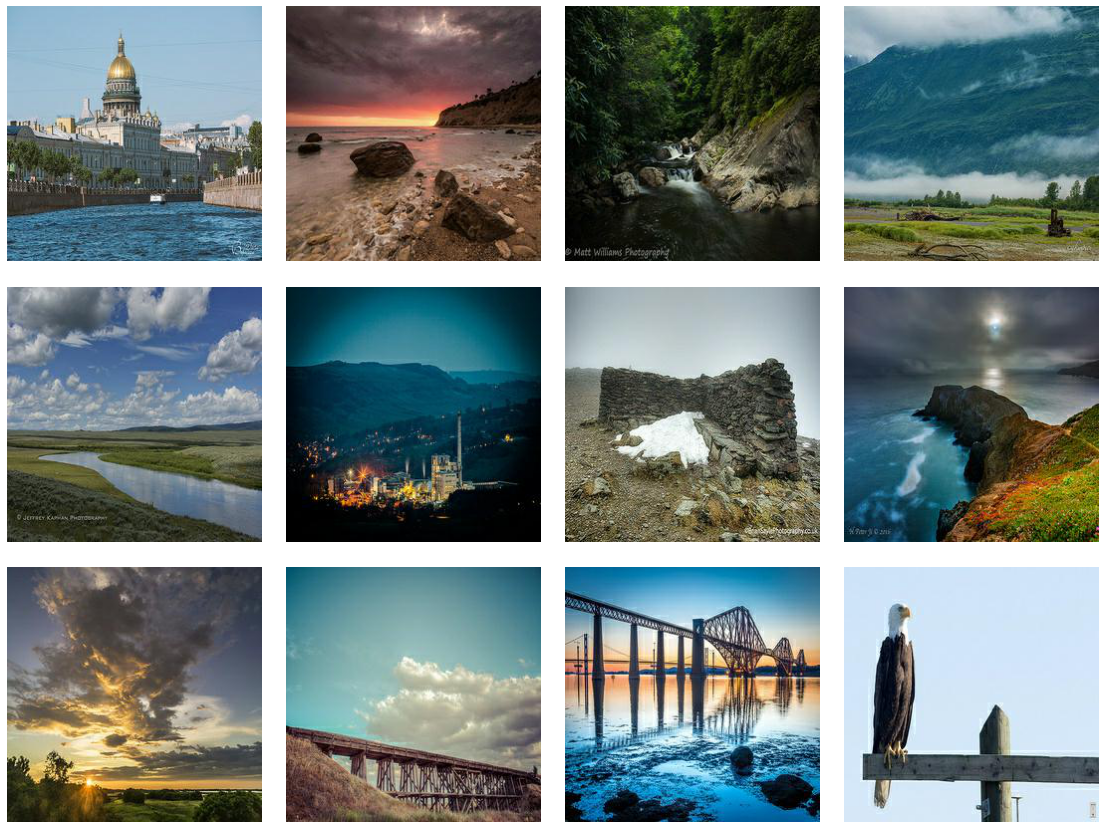

In [16]:
fig = plt.figure(1,figsize=(20,15))
columns = 4
rows = 3
for i in range(rows*columns):
    num = random.randint(2,300)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(PIL.Image.open(photo_files[num]))
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()


# Data Block for CycleGAN

In [17]:
dls = get_dls( photo , monet ,load_size=256,crop_size=256, bs=2, num_workers=0)

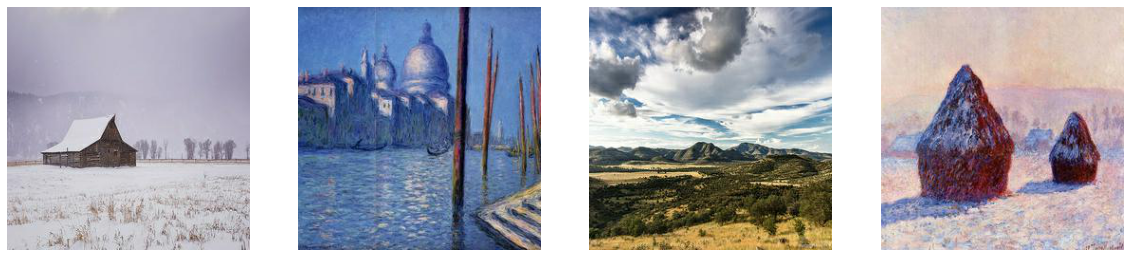

In [18]:
dls.show_batch(figsize=(20,8))

# GPU Check

In [19]:
torch.cuda.get_device_name()

'GeForce RTX 3070'

In [20]:
torch.cuda.empty_cache()

# Create Learner

In [21]:
cycle_gan = CycleGAN(3,3,64, gen_blocks=9)
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999))

/home/stev/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=9.120108734350652e-05)

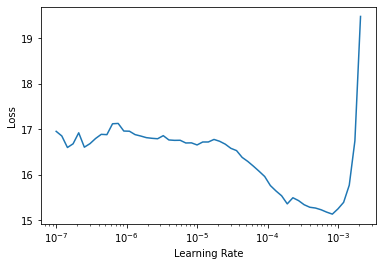

In [22]:
learn.lr_find()

In [23]:
gc.collect()

17806

In [24]:
torch.cuda.empty_cache()

In [29]:
callback_lst=[ShowGraphCallback()]#, SaveModelCallback(monitor='accuracy', every_epoch=False, fname='AutoSave', with_opt=True)]

/home/stev/anaconda3/envs/fastai/lib/python3.6/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


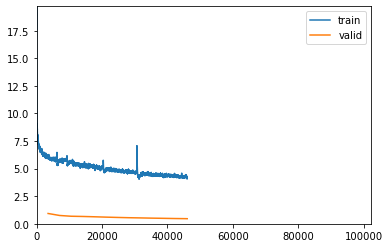

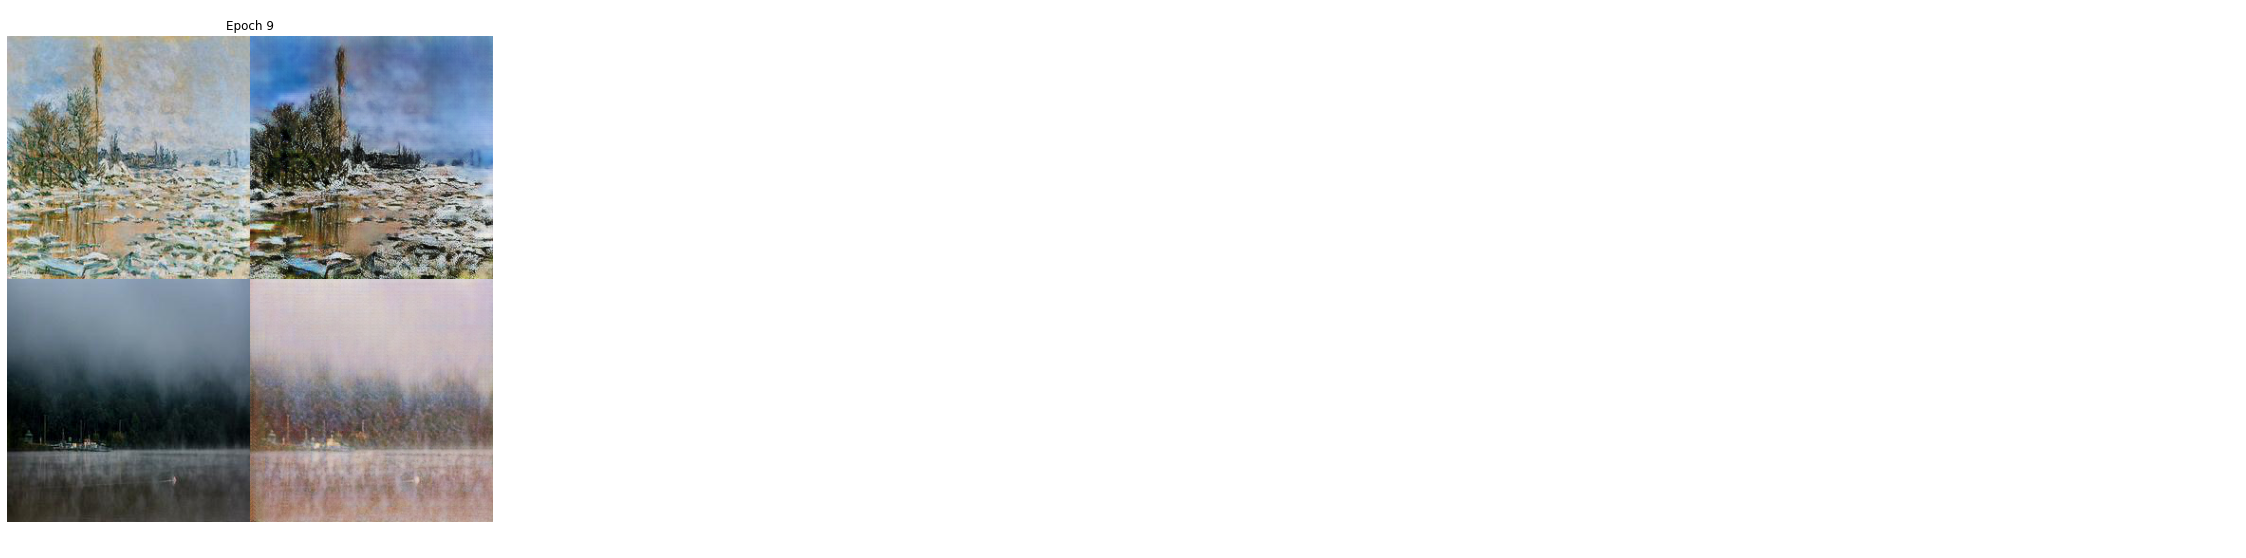

KeyboardInterrupt: 

In [30]:
learn.fit_flat_lin(7 ,7 ,8e-5, cbs=callback_lst)

In [31]:
learn.save('photo2monet');

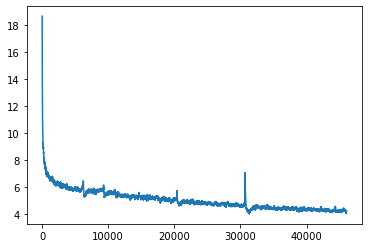

In [32]:
learn.recorder.plot_loss(with_valid=False)

In [33]:
b = dls.train.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

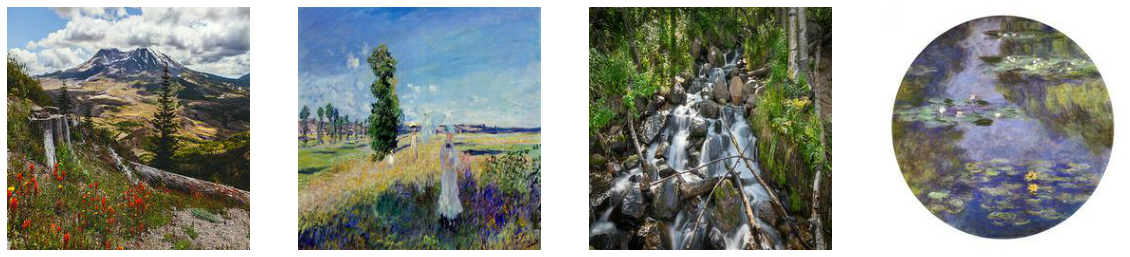

In [34]:
dls.show_batch((b[0], b[1]), max_n=8, show=True,figsize=(20,8))

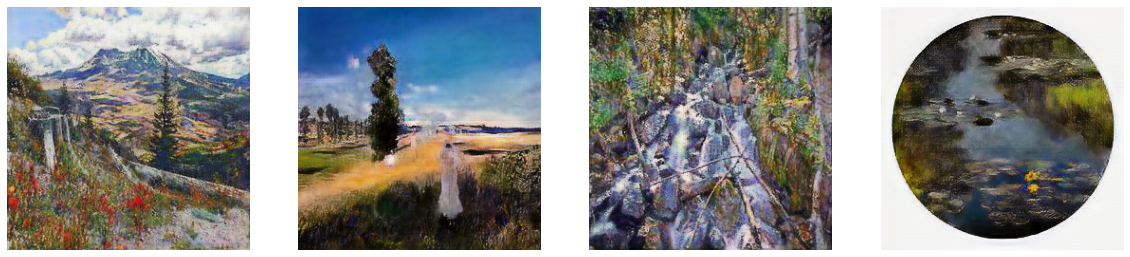

In [35]:
dls.show_batch((preds[1],preds[0]), max_n=8, show=True,figsize=(20,6))

# Test Predictions

In [22]:
learn.load('photo2monet')

/home/stev/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [25]:
torch.cuda.empty_cache()

In [82]:
test_path=str(path/'Test_jpg')
pred_path=path/'Test_Pred_jpg'
#test=get_image_files(test_path)
bs=2
num_workers=0

In [33]:
RESIZE=False
if RESIZE==True:
    fl=get_image_files(test_path)[0]
    img=PIL.Image.open(fl)

    new_shape=(img.shape[1]//4,img.shape[0]//4)
    #img.shape, new_shape

    #img.resize(new_shape)

    bx=min(img.shape)

    x=350
    y=0
    img_fx=img.crop((x,y, bx+x, bx+y)).resize((256,256))
    #img_fx

    fl_rename=str(fl).replace('FullSize','Cropped')

    img_fx.save(fl_rename, "JPEG")

In [86]:
def load_dataset(test_path,bs=4,num_workers=4):
    "A helper function for getting a DataLoader for images in the folder `test_path`, with batch size `bs`, and number of workers `num_workers`"
    dataset = FolderDataset(
            path=test_path,
            transforms=[torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        ) 
    loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=bs,
            num_workers=num_workers,
            shuffle=True
        )
    return loader

In [87]:
def get_preds_cycleGAN(learn,test_path,pred_path,bs=4,num_workers=4,suffix='png'):
    """
    A prediction function that takes the Learner object `learn` with the trained model, 
    the `test_path` folder with the images to perform batch inference on, 
    and the output folder `pred_path` where the predictions will be saved, 
    with a batch size `bs`, `num_workers`,
    and suffix of the prediction images `suffix` (default='png').
    """

    assert os.path.exists(test_path)

    if not os.path.exists(pred_path):
        os.mkdir(pred_path)

    test_dl = load_dataset(test_path,bs,num_workers)
    model = learn.model.G_B.cpu() #.cuda()
    for i, xb in tqdm.tqdm(enumerate(test_dl),total=len(test_dl)):
        fn, im = xb
        preds = (model(im)/2 + 0.5)
        for i in range(len(fn)):
            new_fn = os.path.join(pred_path,'.'.join([os.path.basename(fn[i]).split('.')[0]+'',suffix]))
            torchvision.utils.save_image(preds[i],new_fn)


In [90]:

get_preds_cycleGAN(learn,test_path,pred_path,bs=bs,num_workers=num_workers,suffix='jpg')

100%|██████████| 1/1 [00:08<00:00,  8.14s/it]


In [81]:
import datetime as dt
print(f'Finished: {dt.datetime.now()}')

Finished: 2021-01-03 16:55:24.474761
